In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/Users/lalla-aichaadouim/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [26]:
ne_df = pd.read_csv("ne_train.csv")

In [3]:
ne_df.head()

,date,cat__social_distancing_total_grade_B,cat__social_distancing_total_grade_C,cat__social_distancing_total_grade_C+,cat__social_distancing_total_grade_C-,cat__social_distancing_total_grade_D,cat__social_distancing_total_grade_D+,cat__social_distancing_total_grade_F,cat__social_distancing_visitation_grade_A,cat__social_distancing_visitation_grade_F,...,num__age_85_or_higher,num__immigrant_student_ratio,num__weekend,num__lagged_covid_19_confirmed_cases_15,num__lagged_covid_19_confirmed_cases_30,num__lagged_covid_19_confirmed_cases_45,num__rolling_covid_19_confirmed_cases_15,num__rolling_covid_19_confirmed_cases_30,num__rolling_covid_19_confirmed_cases_45,covid_19_confirmed_cases
0,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,4.440892e-16,-3.469447e-18,-0.627822,-0.801217,-0.758726,-0.722707,-0.869696,-0.909753,-0.975085,0.0
1,2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,4.440892e-16,-3.469447e-18,-0.627822,-0.801217,-0.758726,-0.722707,-0.869696,-0.909753,-0.975085,0.0
2,2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,4.440892e-16,-3.469447e-18,-0.627822,-0.801217,-0.758726,-0.722707,-0.869696,-0.909753,-0.975085,0.0
3,2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,4.440892e-16,-3.469447e-18,1.592808,-0.801217,-0.758726,-0.722707,-0.869696,-0.909753,-0.975085,0.0
4,2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,4.440892e-16,-3.469447e-18,1.592808,-0.801217,-0.758726,-0.722707,-0.869696,-0.909753,-0.975085,0.0


In [116]:
south = pd.read_csv('south_train.csv')

# ARIMA Model: NE


### Check data is stationary using ADF and KPSS test

In [8]:
def adf_test(df):
    adf_result = adfuller(df)
    print('ADF Statistic:', adf_result[0])
    print('p-value:', adf_result[1])
    print('Critical Values:', adf_result[4])
adf_test(ne_df['covid_19_confirmed_cases'])

ADF Statistic: -2.564236262345257
p-value: 0.10061645305278583
Critical Values: {'1%': -3.467004502498507, '5%': -2.8776444997243558, '10%': -2.575355189707274}
The time series is non-stationary (fail to reject the null hypothesis)


In [7]:
def kpss_test(time_series):
    kpss_result = kpss(time_series)
    print('\nKPSS Statistic:', kpss_result[0])
    print('p-value:', kpss_result[1])
    print('Critical Values:', kpss_result[3])
kpss_test(ne_df['covid_19_confirmed_cases'])


KPSS Statistic: 0.34993673179629803
p-value: 0.09873416732918187
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


<AxesSubplot:title={'center':'NE Confirmed Cases Time Series'}, xlabel='date'>

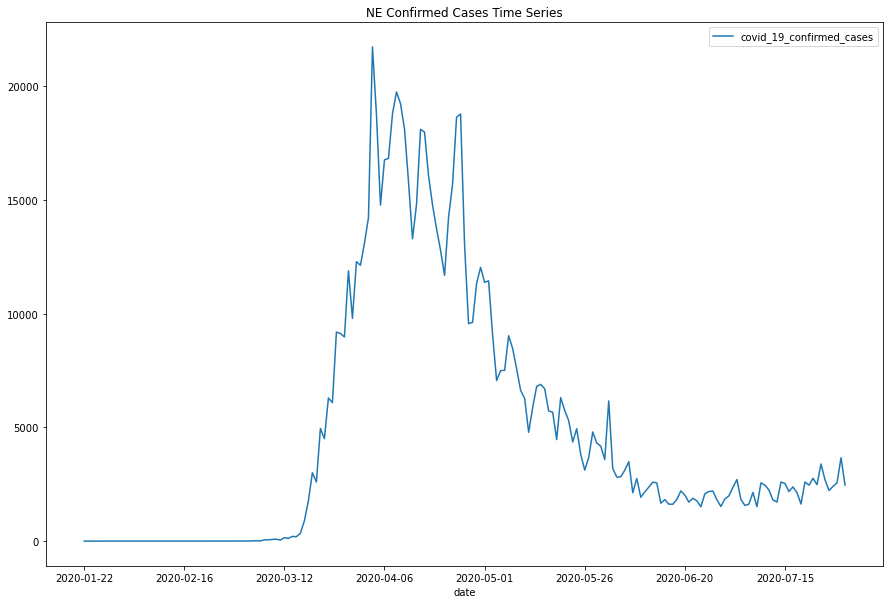

In [49]:
ne_df.plot(x = 'date', y ='covid_19_confirmed_cases', 
           title = 'NE Confirmed Cases Time Series', figsize = (15,10))


### Remove zero from NE df and re-run stationary tests
    # ADF is non-stationary and KPSS shows non-stationary -> remove zeroes to better improve, attempt differncing and log transformation

In [69]:
ne_df_filtered = ne_df[ne_df['covid_19_confirmed_cases'] != 0]

In [70]:
ne_df_filtered['cases_diff'] = ne_df_filtered['covid_19_confirmed_cases'].diff()
ne_df_filtered = ne_df_filtered.dropna()

/var/folders/g7/jzp2y_x97yd3w1yf2x3s7wjc0000gn/T/ipykernel_15227/3158992409.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ne_df_filtered['cases_diff'] = ne_df_filtered['covid_19_confirmed_cases'].diff()


In [71]:
def adf_test(df):
    adf_result = adfuller(df)
    print('ADF Statistic:', adf_result[0])
    print('p-value:', adf_result[1])
    print('Critical Values:', adf_result[4])
adf_test(ne_df_filtered['cases_diff'])

ADF Statistic: -1.9304854143998282
p-value: 0.3178584716509558
Critical Values: {'1%': -3.4769274060112707, '5%': -2.8819726324025625, '10%': -2.577665408088415}


In [72]:
def kpss_test(time_series):
    kpss_result = kpss(time_series)
    print('\nKPSS Statistic:', kpss_result[0])
    print('p-value:', kpss_result[1])
    print('Critical Values:', kpss_result[3])
kpss_test(ne_df_filtered['cases_diff'])


KPSS Statistic: 0.19493467714759954
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/Users/lalla-aichaadouim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


<AxesSubplot:title={'center':'NE Confirmed Cases Time Series (Differencing)'}, xlabel='date'>

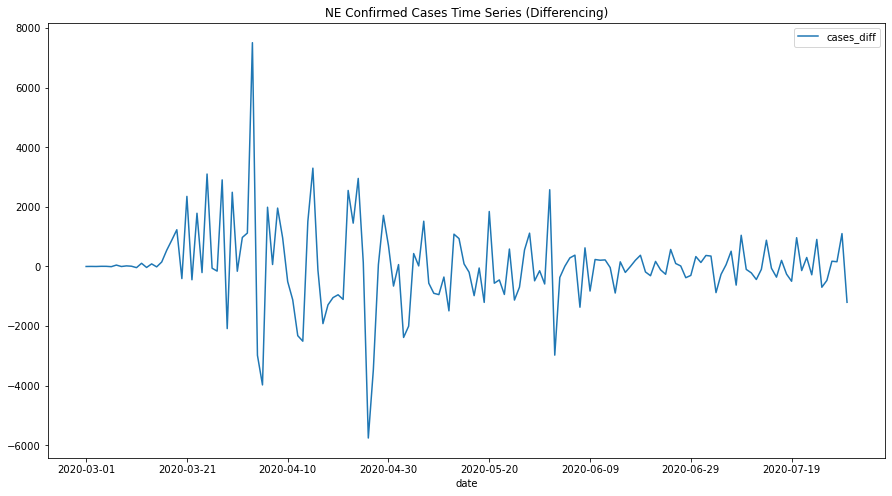

In [76]:
ne_df_filtered.plot(x = 'date', y ='cases_diff', 
           title = 'NE Confirmed Cases Time Series (Differencing)', figsize = (15,8))

In [78]:
ne_df_filtered['cases_log'] = np.log(ne_df_filtered['covid_19_confirmed_cases'])

In [79]:
adf_test(ne_df_filtered['cases_log'])

ADF Statistic: -4.3755382485171435
p-value: 0.00032786112186536555
Critical Values: {'1%': -3.479007355368944, '5%': -2.8828782366015093, '10%': -2.5781488587564603}


In [80]:
kpss_test(ne_df_filtered['cases_log'])


KPSS Statistic: 0.2883152037927226
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/Users/lalla-aichaadouim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


<AxesSubplot:title={'center':'NE Confirmed Cases Time Series (Log Transform)'}, xlabel='date'>

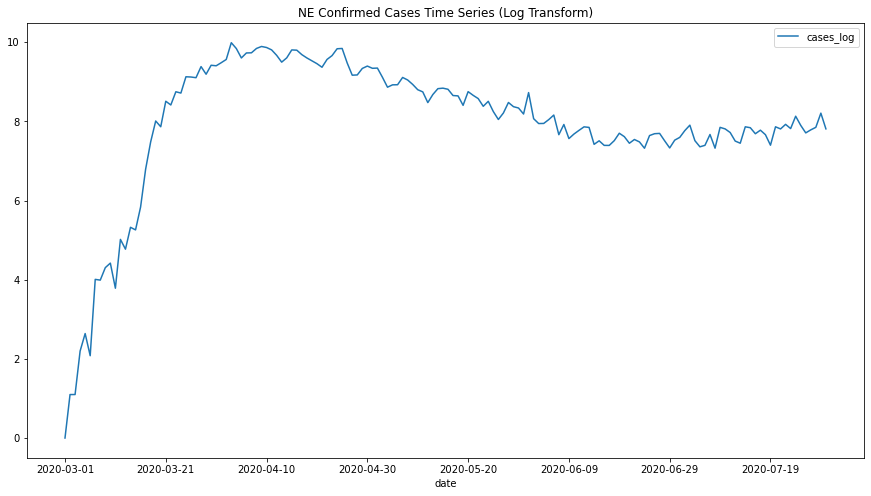

In [81]:
ne_df_filtered.plot(x = 'date', y ='cases_log', 
           title = 'NE Confirmed Cases Time Series (Log Transform)', figsize = (15,8))

#### ADF and KPSS test show that the data becomes stationary with a log transformation

### Autocorrelation Plots

<Figure size 1080x720 with 0 Axes>

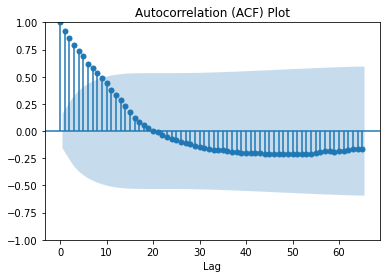

In [101]:
plt.figure(figsize=(15, 10))
plot_acf(ne_df_filtered['cases_log'], lags=65)
plt.title('Autocorrelation (ACF) Plot')
plt.xlabel("Lag")
plt.show()

/Users/lalla-aichaadouim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 864x720 with 0 Axes>

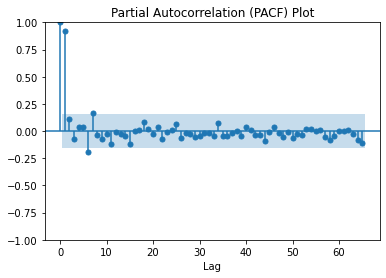

In [96]:
plt.figure(figsize=(12, 10))
plot_pacf(ne_df_filtered['cases_log'], lags=65)
plt.title('Partial Autocorrelation (PACF) Plot')
plt.xlabel("Lag")
plt.show()

Based on the ACF and PACF plots, I will attempt a model with order (1,1,2) and (1,1,1)

### Models

In [104]:
model1 = ARIMA(ne_df_filtered['cases_log'], order=(1, 1, 2))
results1 = model1.fit()
results1.summary()

/Users/lalla-aichaadouim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lalla-aichaadouim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lalla-aichaadouim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              cases_log   No. Observations:                  152
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 -30.751
Date:                Mon, 04 Dec 2023   AIC                             69.503
Time:                        18:27:29   BIC                             81.572
Sample:                             0   HQIC                            74.406
                                - 152                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9940      0.005    217.109      0.000       0.985       1.003
ma.L1         -1.3056      0.055    -23.768      0.000      -1.413      -1.198
ma.L2          0.4004      0.049      8.153      0.000       0.304       0.497
sigma2         0.0867      0.006     13.517      0.000       0.074       0.099
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                59.97
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

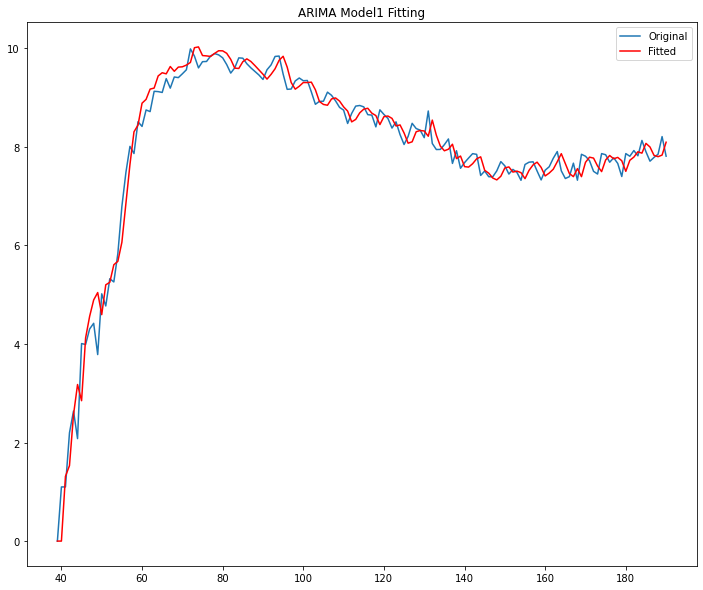

In [107]:
plt.figure(figsize=(12, 10))
plt.plot(ne_df_filtered['cases_log'], label='Original')
plt.plot(results1.fittedvalues, color='red', label='Fitted')
plt.legend()
plt.title('ARIMA Model1 Fitting')
plt.show()

In [105]:
model2 = ARIMA(ne_df_filtered['cases_log'], order=(1, 1, 1))
results2 = model2.fit()
results2.summary()

/Users/lalla-aichaadouim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lalla-aichaadouim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lalla-aichaadouim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              cases_log   No. Observations:                  152
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -47.529
Date:                Mon, 04 Dec 2023   AIC                            101.058
Time:                        18:27:49   BIC                            110.110
Sample:                             0   HQIC                           104.735
                                - 152                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4753      0.271     -1.754      0.079      -1.006       0.056
ma.L1          0.3111      0.278      1.119      0.263      -0.234       0.856
sigma2         0.1099      0.007     16.249      0.000       0.097       0.123
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):               340.71
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               0.18   Skew:                             1.79
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

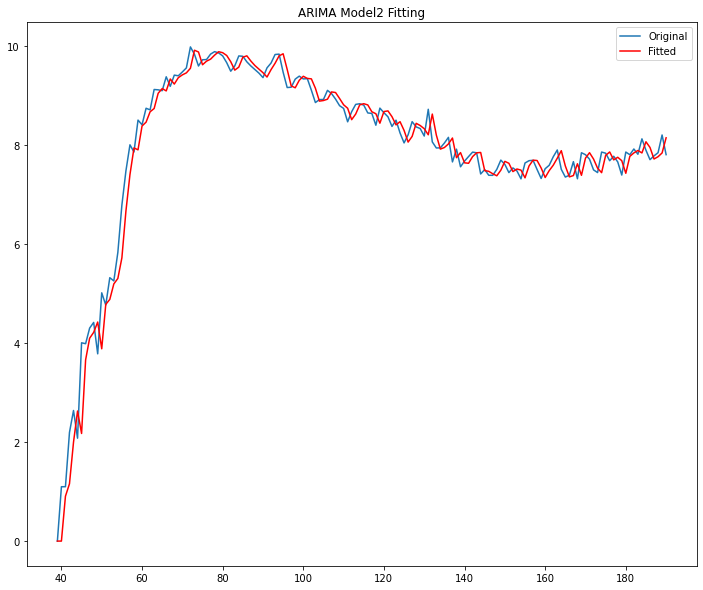

In [108]:
plt.figure(figsize=(12, 10))
plt.plot(ne_df_filtered['cases_log'], label='Original')
plt.plot(results2.fittedvalues, color='red', label='Fitted')
plt.legend()
plt.title('ARIMA Model2 Fitting')
plt.show()

Model 2 appears to be better fitted to the actual data

Calculating MAE and residuals

In [112]:
ne_pred = results2.fittedvalues
mean_absolute_error(np.exp(ne_df_filtered['cases_log']), np.exp(ne_pred))

876.4952604946005

In [114]:
# to prove that model 2 was better fitted, finding mae of model 1 -> mae is higher
ne_pred = results1.fittedvalues
mean_absolute_error(np.exp(ne_df_filtered['cases_log']), np.exp(ne_pred))

1069.8737546450855

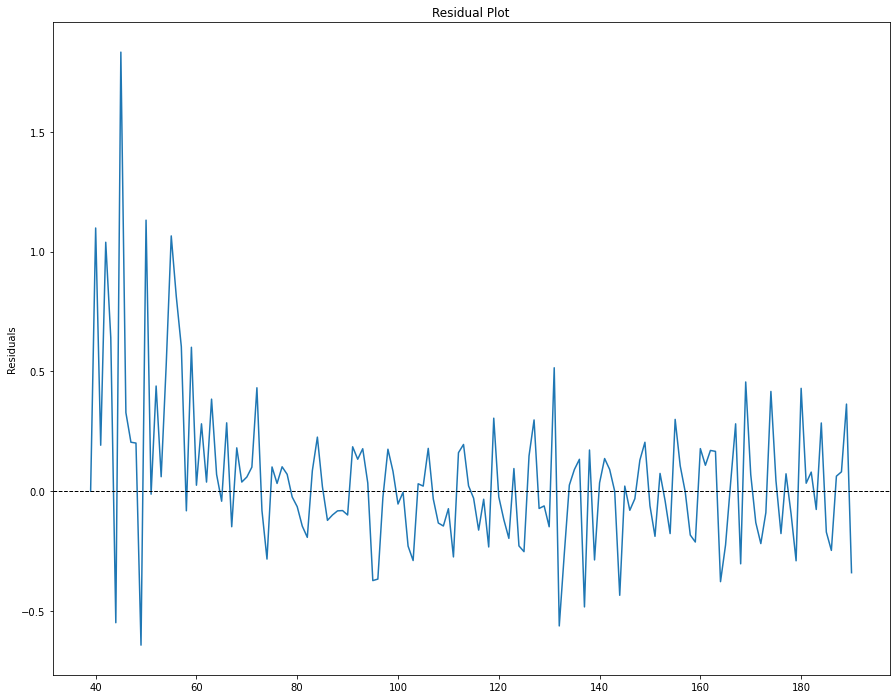

In [115]:
residuals = ne_df_filtered['cases_log'] - results2.fittedvalues

plt.figure(figsize=(15, 12))
plt.plot(residuals)
plt.title('Residual Plot')
plt.ylabel('Residuals')
plt.axhline(0, color='black', linestyle='--', linewidth=1) 
plt.show()

# ARIMA Model - South

In [117]:
adf_test(south['covid_19_confirmed_cases'])

ADF Statistic: -0.3261562885613928
p-value: 0.9217172564737495
Critical Values: {'1%': -3.4680615871598537, '5%': -2.8781061899535128, '10%': -2.5756015922004134}


In [118]:
kpss_test(ne_df['covid_19_confirmed_cases'])


KPSS Statistic: 0.34993673179629803
p-value: 0.09873416732918187
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


#### Tests show that the data is not stationary -> try to transform via log and differencing, also remove zeroes

In [120]:
south_filtered = south[south['covid_19_confirmed_cases'] != 0]
south_filtered['cases_diff'] = south_filtered['covid_19_confirmed_cases'].diff()
south_filtered = south_filtered.dropna()

/var/folders/g7/jzp2y_x97yd3w1yf2x3s7wjc0000gn/T/ipykernel_15227/60567812.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  south_filtered['cases_diff'] = south_filtered['covid_19_confirmed_cases'].diff()


In [121]:
adf_test(south_filtered['cases_diff'])

ADF Statistic: -2.1818114436839036
p-value: 0.21291295394194465
Critical Values: {'1%': -3.479742586699182, '5%': -2.88319822181578, '10%': -2.578319684499314}


In [123]:
kpss_test(south_filtered['cases_diff'])


KPSS Statistic: 0.340330478697287
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/Users/lalla-aichaadouim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


<AxesSubplot:title={'center':'South Confirmed Cases Time Series (Differencing)'}, xlabel='date'>

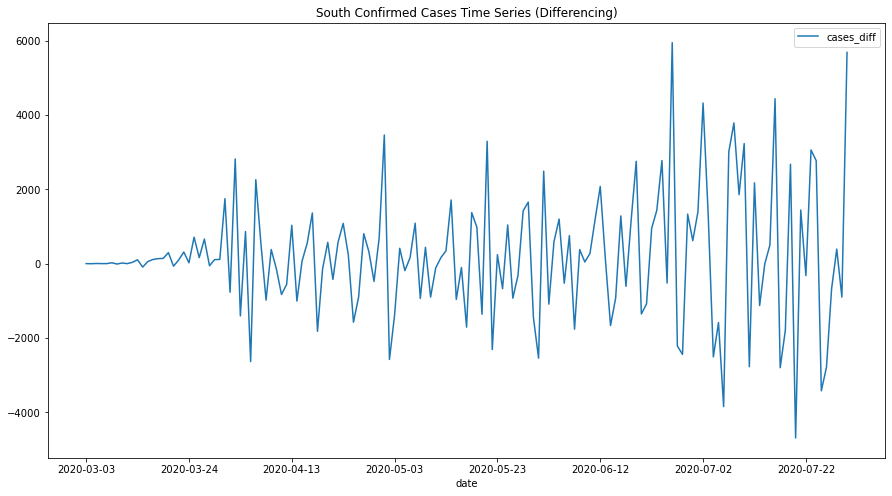

In [124]:
south_filtered.plot(x = 'date', y ='cases_diff', 
           title = 'South Confirmed Cases Time Series (Differencing)', figsize = (15,8))

In [126]:
south_filtered['cases_log'] = np.log(south_filtered['covid_19_confirmed_cases'])

In [128]:
adf_test(south_filtered['cases_log'])

ADF Statistic: -2.0548778936433507
p-value: 0.2630409717849663
Critical Values: {'1%': -3.479742586699182, '5%': -2.88319822181578, '10%': -2.578319684499314}


In [130]:
kpss_test(south_filtered['cases_log'])


KPSS Statistic: 1.1952528654735206
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/Users/lalla-aichaadouim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


<AxesSubplot:title={'center':'South Confirmed Cases Time Series (Log)'}, xlabel='date'>

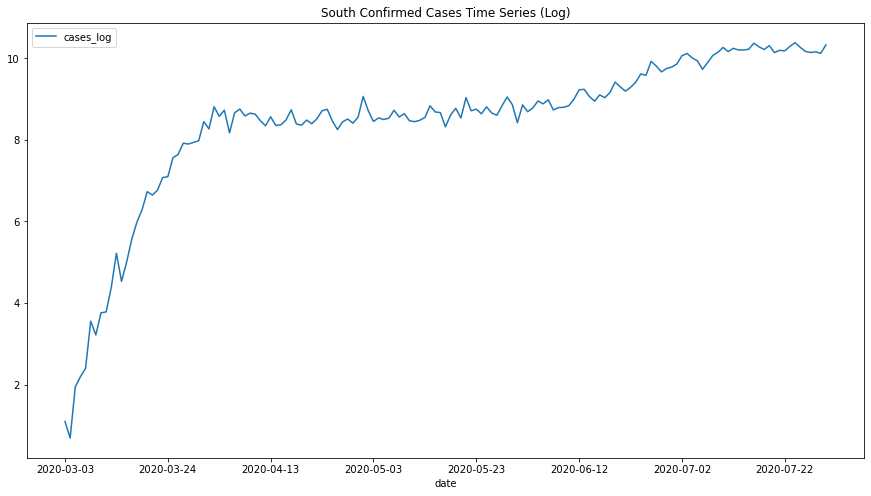

In [131]:
south_filtered.plot(x = 'date', y ='cases_log', 
           title = 'South Confirmed Cases Time Series (Log)', figsize = (15,8))

Log Transformation proved to be better suited for the dataset

### Autocorrelation Plots

<Figure size 1080x720 with 0 Axes>

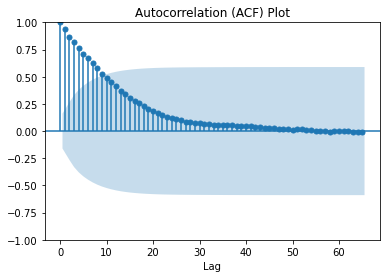

In [134]:
plt.figure(figsize=(15, 10))
plot_acf(south_filtered['cases_log'], lags=65)
plt.title('Autocorrelation (ACF) Plot')
plt.xlabel("Lag")
plt.show()

/Users/lalla-aichaadouim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 864x720 with 0 Axes>

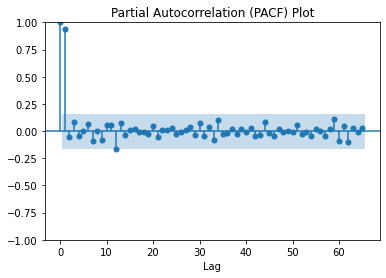

In [135]:
plt.figure(figsize=(12, 10))
plot_pacf(south_filtered['cases_log'], lags=65)
plt.title('Partial Autocorrelation (PACF) Plot')
plt.xlabel("Lag")
plt.show()

### Model

In [157]:
model1 = ARIMA(south_filtered['cases_log'], order=(1, 1, 0))
results1 = model1.fit()
results1.summary()

/Users/lalla-aichaadouim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lalla-aichaadouim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lalla-aichaadouim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              cases_log   No. Observations:                  149
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -18.101
Date:                Mon, 04 Dec 2023   AIC                             40.203
Time:                        19:12:37   BIC                             46.197
Sample:                             0   HQIC                            42.638
                                - 149                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1389      0.057     -2.429      0.015      -0.251      -0.027
sigma2         0.0748      0.005     15.269      0.000       0.065       0.084
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):               118.59
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               0.11   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

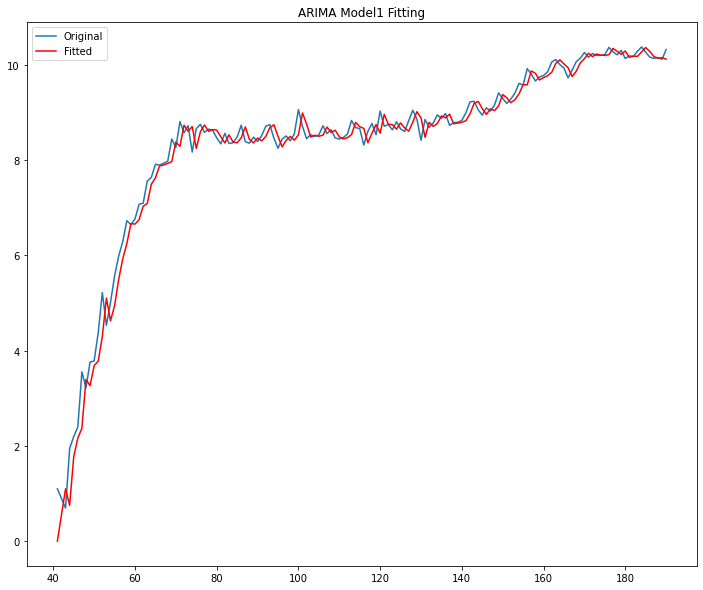

In [158]:
plt.figure(figsize=(12, 10))
plt.plot(south_filtered['cases_log'], label='Original')
plt.plot(results1.fittedvalues, color='red', label='Fitted')
plt.legend()
plt.title('ARIMA Model1 Fitting')
plt.show()

In [159]:
south_pred = results1.fittedvalues
mean_absolute_error(np.exp(south_filtered['cases_log']), np.exp(south_pred))

1188.517183973708

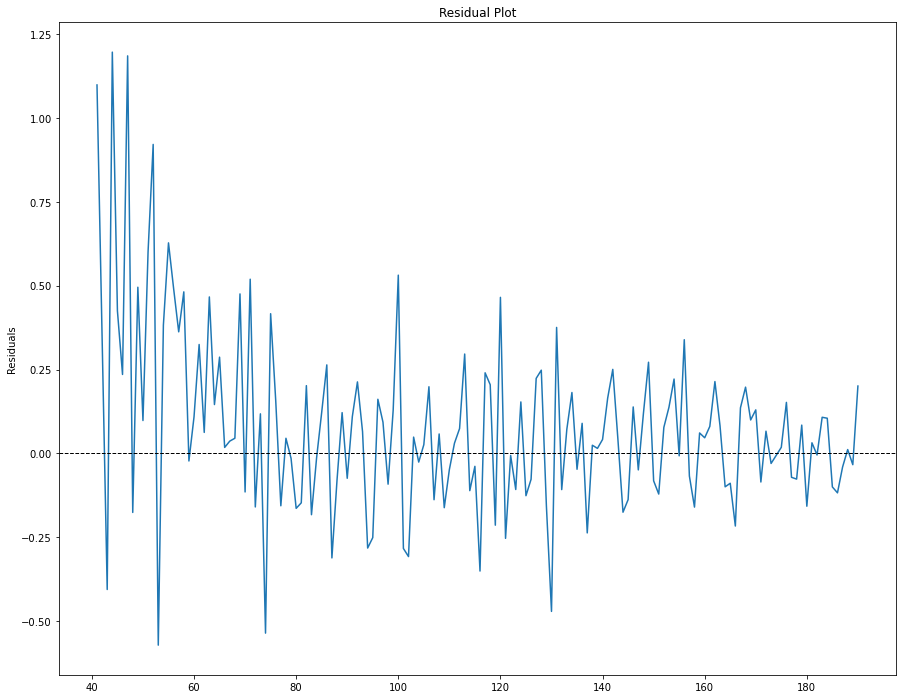

In [161]:
residuals = south_filtered['cases_log'] - results1.fittedvalues

plt.figure(figsize=(15, 12))
plt.plot(residuals)
plt.title('Residual Plot')
plt.ylabel('Residuals')
plt.axhline(0, color='black', linestyle='--', linewidth=1) 
plt.show()